In [1]:
import tensorflow as tf
import numpy as np
import IPython.display as display
import PIL.Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import os
import sys

from utils import *

## Load Some Test Images

In [2]:
castle = cv2.imread('uploads/castle.jpg')
castle = cv2.cvtColor(castle, cv2.COLOR_BGR2RGB)

butterfly = cv2.imread('uploads/butterfly.jpg')
butterfly = cv2.cvtColor(butterfly, cv2.COLOR_BGR2RGB)


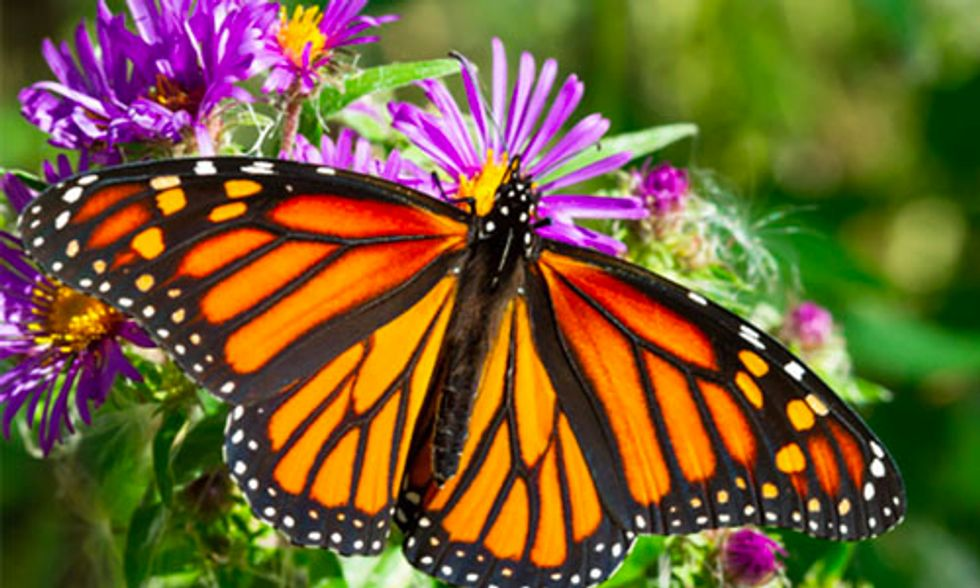

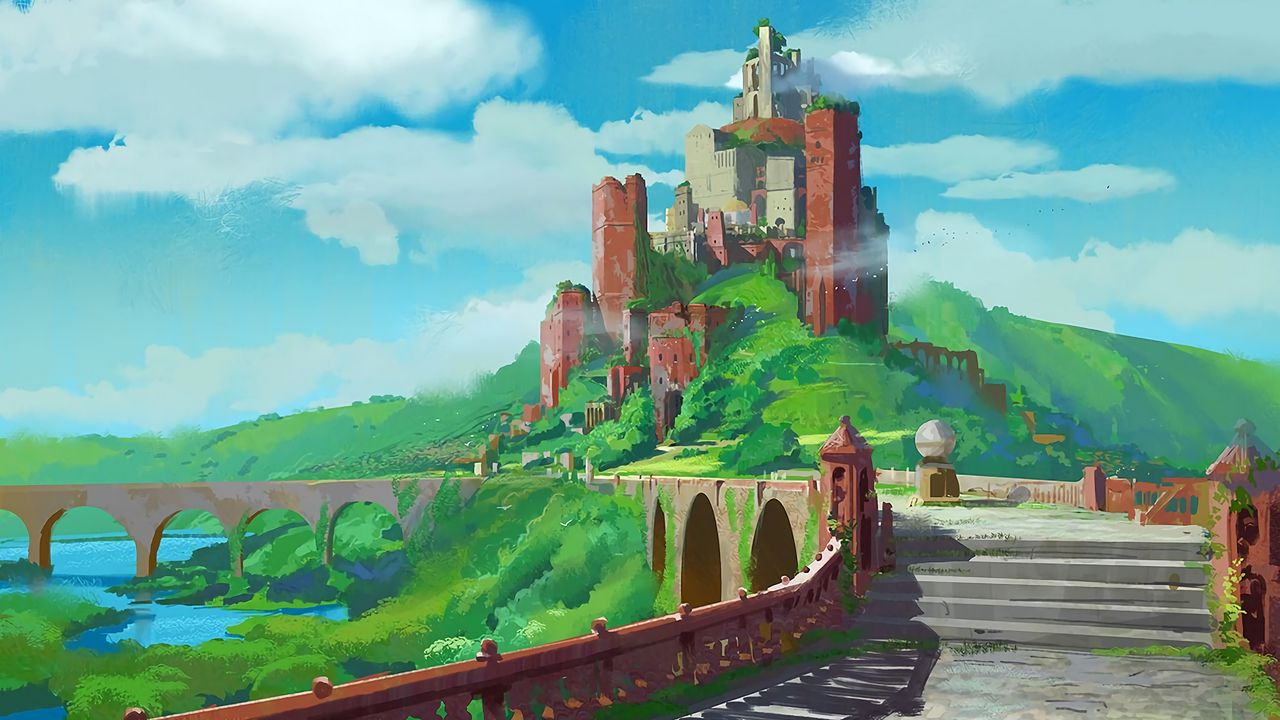

(None, None)

In [3]:
show(butterfly), show(castle)

## Create Random Noise

Text(0.5, 1.0, 'Noise')

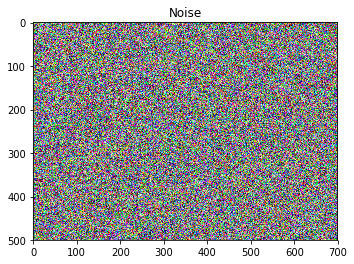

In [4]:
noise = np.random.randint(0, 255,(500,700, 3)) 
plt.imshow(noise)
plt.title('Noise')

## Implement Octave Scaling

Octave scaling allows gradient ascent to be applied at different scales. This can be especially useful when trying to visualize various pattern strengths, or how features manifest along different areas of the gradient.


This code and tensorflow documentation can be found at https://www.tensorflow.org/tutorials/generative/deepdream.

In [5]:
import time

    
def run_deep_dream_with_octaves(img, name, directory, get_tiled_gradients, steps_per_octave=100, lr=0.01, 
                                octaves=range(-2,3), octave_scale=1.3, zoom_factor = 1.01, zoom = True, 
                                save = True, to_show = True, variance = False, var_factor = 0.000001, rotate = False):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    
    
    for octave in octaves:
    # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))
    
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img, variance = variance, var_factor = var_factor)
            img = img + gradients*lr
            img = tf.clip_by_value(img, -1, 1)
            
            if step % 10 == 0:
                display.clear_output(wait=True)
                print ("Octave {}, Step {}".format(octave, step))
                
                if to_show:
                    show(deprocess(img))
            if save:
                save_image(deprocess(img), directory, str(name) + "_" + str(step))
            if zoom:
              
                img = clipped_zoom(img, zoom_factor, rotate)
            
    result = deprocess(img)
    return result

# Calculate Loss

In Deep Dream, the loss is the sum of activations of all layers. Usually we are trying to minimize loss, the difference between our predicted output and desired output, but in Deep Dream we want to maximize the activation of our layers. We normalize the loss at each layer to evenly weigh differences between large and small layers. We will maximize the loss using gradient ascent. 

I also added total_varation to the loss function at the gradient step by using ```tf.image.total_variation()```, allowing the user to smoothen the gradient if they desire with the ```variance``` boolean.

In [6]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
    
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

In [7]:
class TiledGradients(tf.Module):
    
    def __init__(self, model):
        self.model = model

    def __call__(self, img, tile_size=512, variance = False, var_factor = 0.000001):
        shift, img_rolled = random_roll(img, tile_size)

        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
            # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)
                    if variance:
                        loss = loss- var_factor*tf.reduce_sum(tf.image.total_variation(img_tile))

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients

# Creating a Dreamer

This class loads a state-of-the-art image recognition model, Resnet101, InceptionV3, or VGG16, extracting the layers and allowing the user to visualize them through gradient ascent with any desired input image.

Consider playing around with different hyperparameters when you build your Dreamer!

In [8]:
class Dreamer():
    
    def __init__(self, model, output_dir = 'outputs', steps_per_octave = 100, lr = 0.001, octaves = range(-2,0),
                octave_scale = 1.4, zoom_factor = 1.0066, zoom = False, save = False,
                to_show = True, variance = True, var_factor = 1/20000000, rotate = False):
        self.model = model
        self.output_dir = output_dir
        self.steps_per_octave = steps_per_octave
        self.lr = lr
        self.octaves = octaves
        self.octave_scale = octave_scale
        self.zoom_factor = zoom_factor
        self.zoom = zoom
        self.save = save
        self.to_show = to_show
        self.variance = variance
        self.var_factor = var_factor
        self.rotate = rotate
        self.build_layers(model)
    
    def build_layers(self, model):
        
        ## Load the Pretrained Models and Extract the Concatenation/Add Layers
        model = model.lower()
        if 'inception' in model:
            self.base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
            self.concat_layers = [layer.name for layer in self.base_model.layers if 'mixed' in layer.name]
            self.concat_layers = [self.base_model.get_layer(name).output for name in self.concat_layers][:7]
        elif 'resnet' in model:
            self.base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
            self.concat_layers = [layer.name for layer in self.base_model.layers if 'add' in layer.name]
            self.concat_layers = [self.base_model.get_layer(name).output for name in self.concat_layers]
        elif 'vg' in model:
            self.base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
            self.concat_layers = [layer.name for layer in self.base_model.layers if 'block' and '_conv' in layer.name]
            self.concat_layers = [self.base_model.get_layer(name).output for name in self.concat_layers]
        else:
            self.model = input('Please Re-enter the Model Name\nTry Resnet, Inception, or VGG16: ')
            self.build_layers(self.model)
        
        
        
    
    def __call__(self, img, output_dir = None, img_name = 'test', layers = None):
        
        if output_dir != None:
            self.output_dir = output_dir
         ## Layer Selection
        if layers == None:
            layers = [self.concat_layers[0], self.concat_layers[-1]]
        
        ## Create Feature Extraction Network
        dream_model = tf.keras.Model(inputs=self.base_model.input, outputs=layers)       
        get_tiled_gradients = TiledGradients(dream_model)
        
        dream = run_deep_dream_with_octaves(img, img_name, self.output_dir, get_tiled_gradients, self.steps_per_octave, self.lr,  
                                self.octaves, self.octave_scale, self.zoom_factor, self.zoom, 
                                self.save, self.to_show, self.variance, self.var_factor, self.rotate)
        return dream
    
    def visualize_layers(self, noise, save_layers = True, layers = None):
        
        if layers == None:
            layers = self.concat_layers
            
        ## Visualize maximal activations of each layer
        for layer in layers:
            try:
                dream_model = tf.keras.Model(inputs=self.base_model.input, outputs=[layer])        ## Layer Selection
                get_tiled_gradients = TiledGradients(dream_model)
                dream = run_deep_dream_with_octaves(noise, self.model + "_" + layer.name, self.output_dir, 
                                                    get_tiled_gradients, steps_per_octave=100, lr=0.02, 
                                                    octaves=range(-4,0), octave_scale=1.8, zoom_factor = 1.001, 
                                                    zoom = False, save = False, to_show = True, variance =self.variance, 
                                                    var_factor = self.var_factor)
                if save_layers:
                    save_image(dream,  self.model + '_' + self.output_dir, self.model + str(layer.name).split('/')[0])
            
            except:
                print("Error at ", layer.name)

In [74]:
steps_per_octave=200
lr=0.003
octaves=range(-5, 0)
octave_scale=1.8
zoom_factor = 1.1
zoom = False
save = False
to_show = True
variance = True
var_factor = 1/40000000

dreamer = Dreamer('vgg', 'outputs', steps_per_octave, lr, octaves, octave_scale, zoom_factor, zoom, save, to_show,
       variance, var_factor)

Octave -1, Step 190


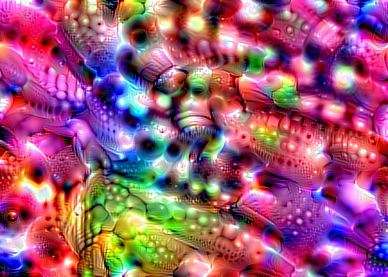

In [75]:
output_img = dreamer(noise)

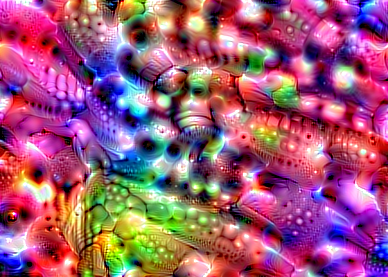

In [76]:
show(output_img)

Octave 0, Step 190


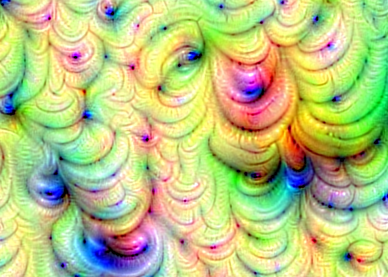

In [86]:
dreamer.lr = 0.05
dreamer.var_factor = 1/80000000 * 20
dreamer.variance = False
dreamer.zoom = True
dreamer.octave_scale = 1
dreamer.zoom_factor = 1.04
dreamer.octaves = range(0,1)
dreamer.save = True
dreamer.rotate = True
dreamer.steps_per_octave = 200
final_img = dreamer(output_img, layers = [dreamer.concat_layers[8]])

## Visualize All Layers of the Model

In [82]:
#dreamer.visualize_layers(noise, layers = [dreamer.concat_layers[-2]])

## Generate GIFs Of Dreaming

In [83]:
import imageio
imageio.help(name = 'gif')

GIF-PIL - Static and animated gif (Pillow)

    A format for reading and writing static and animated GIF, based
    on Pillow.
    
    Images read with this format are always RGBA. Currently,
    the alpha channel is ignored when saving RGB images with this
    format.
    
    Parameters for reading
    ----------------------
    None
    
    Parameters for saving
    ---------------------
    loop : int
        The number of iterations. Default 0 (meaning loop indefinitely).
    duration : {float, list}
        The duration (in seconds) of each frame. Either specify one value
        that is used for all frames, or one value for each frame.
        Note that in the GIF format the duration/delay is expressed in
        hundredths of a second, which limits the precision of the duration.
    fps : float
        The number of frames per second. If duration is not given, the
        duration for each frame is set to 1/fps. Default 10.
    palettesize : int
        The number of colors t

In [84]:
def generate_gif(img_dir = 'outputs', output_dir = 'movie.gif'):
    
    folder = img_dir
    files = [f"{folder}\\{file}" for file in os.listdir(folder)]

    ## Sort the strings numerically, instead of alphabetically
    int_list = [int(name.split('_')[1].split('.')[0]) for name in files]
    indexes = [str(i) for i in range(min(int_list), max(int_list)+1)]

    zipped_list = zip(int_list, indexes)
    sorted_list = sorted(zipped_list)
    tuples = zip(*sorted_list)
    int_list, indexes = [ list(tuple) for tuple in  tuples]
    files = [files[int(i)] for i in indexes]


    images = [imageio.imread(file) for file in files]
    imageio.mimwrite(output_dir, images, fps=20)

In [85]:
generate_gif()


# Next Steps:


1. Save Yaml of Hyperparameters when save = True

2. Change save boolean to a directory, where all files will go

3. Make sure to change the file name for each octave, so that gifs can be made for each octave

4. Add Gif Generator that references target directory and create gif at outputdirectory
